# Lab 4: Text Processing
*Due: Friday April 1st*


In this lab, you will use some of the text similarity concepts presented in lecture for two simple applications: sentence completion, and a basic question-and-answer service.

## Part 1: Text similarity fundamentals (20 pts)

In this part of the lab, we will walk you through some of the text similarity approaches presented in lecture once again, as a basis for the later parts. The overall goal of this part is to determine the similarity bewtween pairs of sentences drawn from `korn_sen` below.

### 1.1 Setup
First, run the cells below to import necessary packages and define helper functions.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.feature_extraction
import nltk.stem.porter 
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import re, json, requests

np.set_printoptions(precision=2)

In [13]:
korn_sen = [
    "Tim loves the band Korn.",
    "Tim adores the rock group Korn.",
    "Tim loves eating corn.",
    "Tim used to love Korn, but now he hates them.",
    "Tim absolutely loves Korn.",
    "Tim completely detests the performers named Korn",
    "Tim has a deep passion for the outfit the goes by the name of Korn",
    "Tim loves listening to the band Korn while eating corn."
]

In [14]:
def plot_sim_matrix(m,sens):
    cmap = cm.get_cmap('RdYlGn')
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(m, interpolation='nearest', cmap=cmap)
    ax.grid(True)
    plt.title('San Francisco Similarity matrix')
    plt.xticks(range(len(sens)), sens, rotation=90);
    plt.yticks(range(len(sens)), sens);
    fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
    plt.show()

stemmer = nltk.stem.porter.PorterStemmer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

analyzer = sklearn.feature_extraction.text.CountVectorizer(stop_words='english').build_analyzer()
list(stemmed_words(korn_sen[0]))

['tim', 'love', 'band', 'korn']

### 1.2 Jaccard vs Cosine similarity (10 pts)
A simple appoach to tokenization would follow the bag-of-words model, vectorizing each sentence based on token counts. Run the code below to perform this task. Then, compute the matrix of Jaccard and cosine similarities among the sentences

In [15]:
def jaccard(s1, s2):
    j = float(len(s1.intersection(s2))) / float(len(s1.union(s2)))
    return j

def bag_jaccard(sen):
    out = np.zeros((len(sen),len(sen)))
    for i in range(len(sen)):
        s = re.sub(r'[^\w\s]', '', sen[i])
        sen1 = set(s.split(" "))
        for j in range(len(sen)):
            s = re.sub(r'[^\w\s]', '', sen[j])
            sen2 = set(s.split(" "))

            out[i][j] = jaccard(sen1, sen2)

    plot_sim_matrix(out, sen)

In [16]:
def bag_cosine(sen):

    f = sklearn.feature_extraction.text.CountVectorizer(analyzer=stemmed_words)
    
    #Count vectorizer translates each document into a vector of counts
    X = f.fit_transform(sen)

    print(f.get_feature_names_out())

    #cosine_similarity computes the cosine similarity between
    #a set of vectors
    cos_sim = cosine_similarity(X)

    plot_sim_matrix(cos_sim, sen)

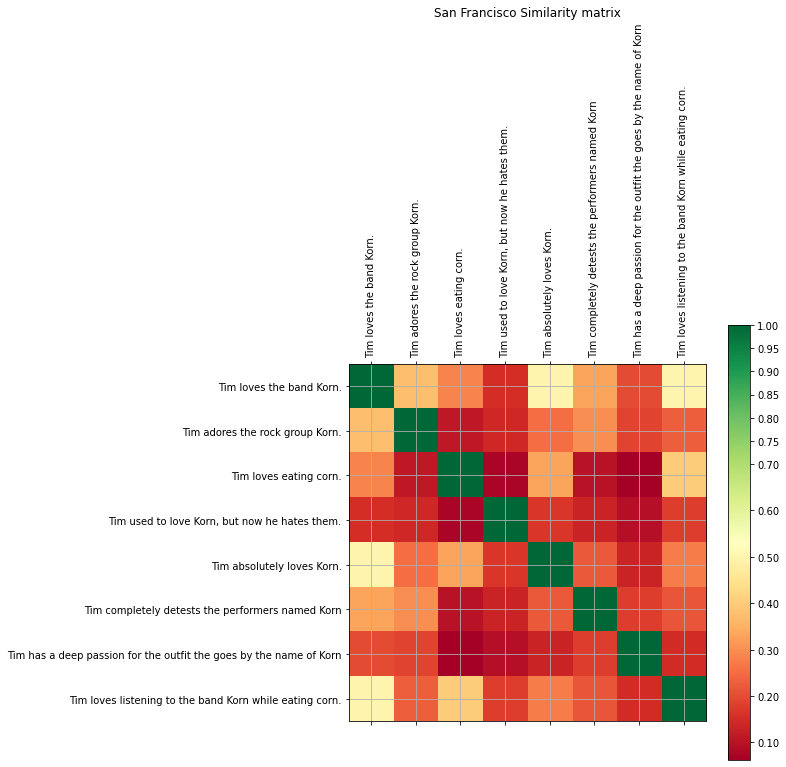

In [17]:
bag_jaccard(korn_sen)

['absolut' 'ador' 'band' 'complet' 'corn' 'deep' 'detest' 'eat' 'goe'
 'group' 'hate' 'korn' 'listen' 'love' 'name' 'outfit' 'passion' 'perform'
 'rock' 'tim' 'use']


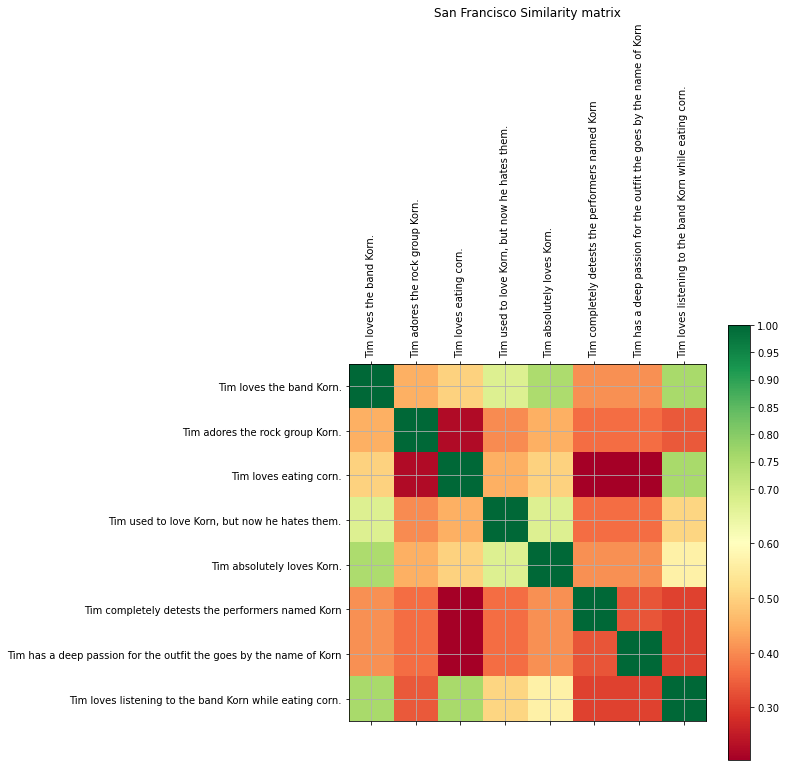

In [18]:
bag_cosine(korn_sen)

**Question (10 pts)**: Contrast the two similarity matrices above, explaining the technical source of the discrepancies. You don't need to explain every pair of sentences for which they differ; provide examples and the general principle. What types of input would each similarity metric be best suited for?

**Answer**:

With "Tim absolutely loves Korn" versus "Tim loves the band Korn", the San Francisco similarity matrix correctly determines that the two phrases are highly similar. However, Jaccard matrix only determines moderate similarity. The cosine similarity method performs better because its training corpus reveals that "absolutely adores" and "adores" mean the same thing. The Jaccard metric simply regards these phrases as dissimilar.



### 1.3 TF/IDF (5 pts)

A more elaborate approach, in contrast to bag-of-words, is TF/IDF. Below are two ways to implement it in Python.

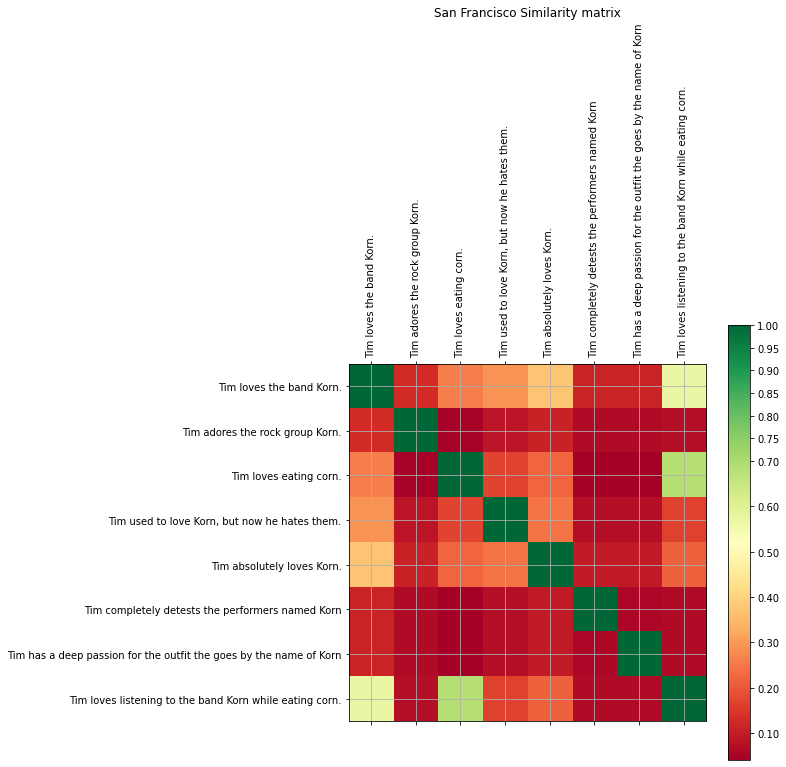

In [19]:
def do_tf_idf_full(sen):
    #from scratch
    f = sklearn.feature_extraction.text.CountVectorizer(analyzer=stemmed_words)
    X = f.fit_transform(sen)
    cnts_ar = np.array(X.toarray()).sum(axis=0)

    doc_len_ar = np.array(X.toarray()).sum(axis=1)
    #should count number of documents where term appears, not just sum, 
    # but ok because our corpus doesn't repeat words
    idf_ar = np.log((1.0/cnts_ar) * len(sen)) + 1
    tdf_out = (np.array(X.toarray()).T/(doc_len_ar)).T * idf_ar
    cos_sim = cosine_similarity(tdf_out)

def do_tf_idf_sklearn(sen):
    #using sklearn
    f  = sklearn.feature_extraction.text.TfidfVectorizer(analyzer=stemmed_words,smooth_idf=False,norm='l1')
    X = f.fit_transform(sen)
    cos_sim = cosine_similarity(X)
    plot_sim_matrix(cos_sim, sen)

do_tf_idf_sklearn(korn_sen)

**Question (5 pts)**: Describe the quality of the output and compare it to part 1.2. Which of the drawbacks of bag-of-words can TF/IDF help mitigate, if any? 



### 1.4 BERT (5 pts)

Finally, we can use a more sophisticated model like BERT to produce the similarity matrix among the given sentences.

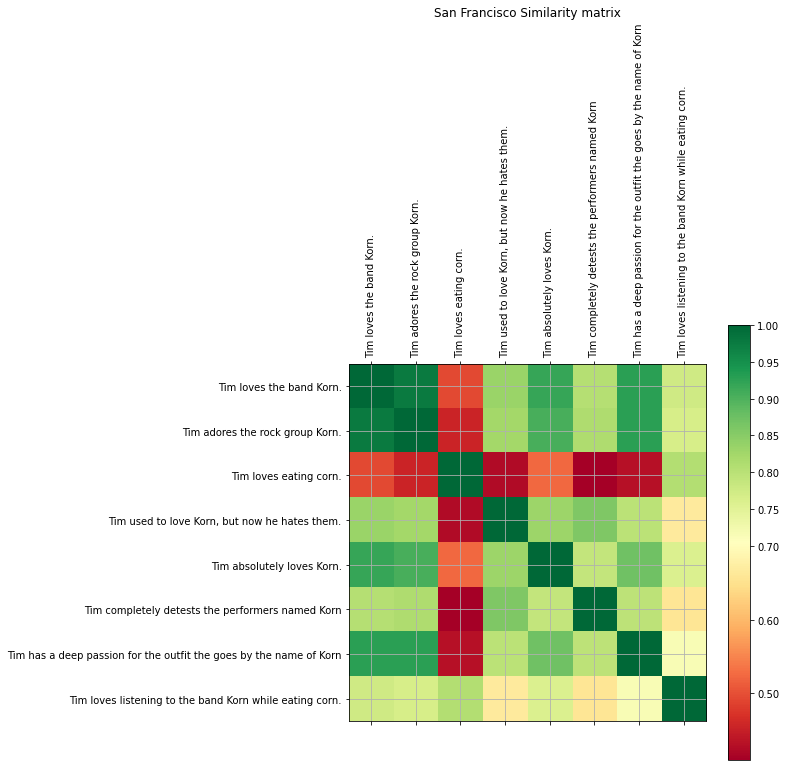

In [20]:
def do_bert(sen):

    model = SentenceTransformer('all-mpnet-base-v2')
    sen_embeddings = model.encode(sen)

    #let's calculate cosine similarity for sentence 0:
    cos_sim = cosine_similarity(sen_embeddings)

    plot_sim_matrix(cos_sim, sen)

do_bert(korn_sen)

**Question (5 pts)**: Describe the quality of the output and compare it to the previous 2 parts. Are there any sentences that remain difficult for BERT?

BERT is far better at similarity detection than the previous two parts, especially with

The pair "Tim loves listening to the band Korn while eating corn" and "Tim used to love Korn, but now he hates them" should be considered dissimilar, but BERT still has some trouble detecting this delayed negation.

## Part 2: Sentence completion (35 pts)

In this part of the lab, you will use text similarity in the context of a sentence completion task. Given a dataset of sentences, and the beginning of a sentence, your goal will be to determine the most similar sentence in the dataset.

### 2.1 The Dataset

For this part, we will use a crowdsourced dataset including the first sentence of different novels, available [here](https://github.com/janelleshane/novel-first-lines-dataset).

Run the cell below to download the dataset.

In [21]:
url = "https://raw.githubusercontent.com/janelleshane/novel-first-lines-dataset/master/crowdsourced_all.txt"
resp = requests.get(url)

sentences = resp.text.split("\n")
sentences

['Enter the first sentence of a novel.',
 'Call me Ishmael.',
 "The student wouldn't stop doing her homework, and it was going to kill her.",
 'To become the caretaker of Elaragnia, the Alezrani must give up part of their soul so they may interact with the universe at its deepest levels',
 'The unicorn lived in a lilac wood, and she lived all alone.',
 'I have made my decision, Bacchus. ',
 'The fetch is one of the most feared and least understood figures in Faerie.',
 'The day the earth shook and a stranger fell from the sky, was the same day that Peregrine “Peri” Smythe was stuck in a tree.',
 'As the clock ticked down on her senior year in high school, Laurel McBane learned one indisputable fact.',
 'Smoke and the cloying scent of chems hung thick in the air. ',
 'Sylvie skipped along to the tune spilling from her Pip Boy, hopping from one side of the train tracks to the other. ',
 'It was nearing dark when they passed the ruins of a Red Rocket Station and the boss eagerly picked up

### 2.2 Pre-processing (10 pts)

**Task (5 pts)**: To determine sentence similarity, we would like to pre-process the sentences. However, we still want to retain a copy of the original sentences around, for our final reply to the user. Create a copy of `sentences` in `match`, retaining the sort order of the sentences. Then, remove any duplicate sentences from both `sentences` and `match`, and stem the words in `match`.

In [22]:
match = sentences.copy()

# Your de-duplication code here
sentences = list(dict.fromkeys(sentences))
match = list(dict.fromkeys(match))

# Your stemming code here
stemmer = nltk.stem.porter.PorterStemmer()
stemmed_match = []
for sentence in match:
    stemmed_sentence = ""
    for word in sentence.split(" "):
        stemmed_sentence += stemmer.stem(word) + " "
    stemmed_sentence = stemmed_sentence[:-1]
    stemmed_match.append(stemmed_sentence)
match = stemmed_match
match

['enter the first sentenc of a novel.',
 'call me ishmael.',
 "the student wouldn't stop do her homework, and it wa go to kill her.",
 'to becom the caretak of elaragnia, the alezrani must give up part of their soul so they may interact with the univers at it deepest level',
 'the unicorn live in a lilac wood, and she live all alone.',
 'i have made my decision, bacchus. ',
 'the fetch is one of the most fear and least understood figur in faerie.',
 'the day the earth shook and a stranger fell from the sky, wa the same day that peregrin “peri” smyth wa stuck in a tree.',
 'as the clock tick down on her senior year in high school, laurel mcbane learn one indisput fact.',
 'smoke and the cloy scent of chem hung thick in the air. ',
 'sylvi skip along to the tune spill from her pip boy, hop from one side of the train track to the other. ',
 'it wa near dark when they pass the ruin of a red rocket station and the boss eagerli pick up the pace.',
 "look, i didn't want to be a half-blood.",


**Task (5 pts)**: Remove stopwords and punctuation from `match` . Provide some indicative metrics related to this pre-processing step (e.g. the most frequent X words before and after stopword removal, or the proportion of words that were stopwords).

In [23]:
# Your punctuation and stopword removal code here
original_match = match.copy()

stop_words = set(stopwords.words('english'))
for sentence in match:
    original_sentence = sentence
    sentence = re.sub(r'[^\w\s]', '', sentence)
    sentence = sentence.lower()
    sentence = sentence.split(" ")
    sentence = [w for w in sentence if not w in stop_words]
    sentence = " ".join(sentence)
    match[match.index(original_sentence)] = sentence
match

['enter first sentenc novel',
 'call ishmael',
 'student wouldnt stop homework wa go kill',
 'becom caretak elaragnia alezrani must give part soul may interact univers deepest level',
 'unicorn live lilac wood live alone',
 'made decision bacchus ',
 'fetch one fear least understood figur faerie',
 'day earth shook stranger fell sky wa day peregrin peri smyth wa stuck tree',
 'clock tick senior year high school laurel mcbane learn one indisput fact',
 'smoke cloy scent chem hung thick air ',
 'sylvi skip along tune spill pip boy hop one side train track ',
 'wa near dark pass ruin red rocket station boss eagerli pick pace',
 'look didnt want halfblood',
 'boss squint binocular clump stiff brown grass tower tangl roads ',
 'quiet sever small moments',
 'thing start befor things',
 'zombi eat someone brain screen grandad old tv',
 'true work explosives',
 'sometimes bit tragedi real life cant structur like film',
 'neither grime sister would happi life look back alway seem troubl began p

##### Stopword/Punctuation removal **metrics**

In [24]:
from collections import Counter

proportion_stopwords = 1 - (sum(len(s) for s in match)/sum(len(s) for s in original_match))
print(f"Proportion of stopwords removed: {proportion_stopwords}")

# Get the most frequent words
original_freq_words = Counter(w for s in original_match for w in s.split(" "))
freq_words = Counter(w for s in match for w in s.split(" "))
print(f"Most frequent words BEFORE stopword/punctuation removal: {original_freq_words.most_common(5)}")
print(f"Most frequent words AFTER stopword/punctuation removal: {freq_words.most_common(5)}")

Proportion of stopwords removed: 0.33615041136975776
Most frequent words BEFORE stopword/punctuation removal: [('the', 13786), ('of', 6313), ('a', 5080), ('and', 4596), ('in', 3685)]
Most frequent words AFTER stopword/punctuation removal: [('wa', 3003), ('sand', 2057), ('', 1796), ('hi', 1332), ('one', 646)]


### 2.3 Completing the sentences (15 pts)

**Task (3 pts)**: Fill in the function below, to apply the same preprocessing to incoming sentences, as you applied to the sentences in `match`.

In [25]:
def preprocess_sentence(s):
    processed_s = s
    
    # stem the sentence
    stemmer = nltk.stem.porter.PorterStemmer()
    stemmed_sentence = ""
    for word in processed_s.split(" "):
        stemmed_sentence += stemmer.stem(word) + " "
    processed_s = stemmed_sentence[:-1]
    
    # remove punctuation
    processed_s = re.sub(r'[^\w\s]', '', processed_s)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    processed_s = processed_s.lower()
    processed_s = processed_s.split(" ")
    processed_s = [w for w in processed_s if not w in stop_words]
    processed_s = " ".join(processed_s)

    return processed_s

processed_match = [ preprocess_sentence(s) for s in sentences ]

# If written correctly, then there is no difference between processed_match and match
print(f"Is preprocess_sentence correct? {set(processed_match) - set(match) == set()}")


Is preprocess_sentence correct? True


**Task (12 pts)**: Fill in the function below, to retrieve the sentence **most similar** to `s`. Your implementation should allow toggling between cosine and Jaccard similarity in the bag-of-words model, as well as switching to TF/IDF or BERT, using the value of `option` (one of the strings in `options`). You are free to define additional variables outside `complete`, if needed.

In [182]:
import os
options = ["BAG_COSINE", "BAG_JACCARD", "TF/IDF", "BERT"]

# Your variables here
corpus = [preprocess_sentence(s) for s in sentences]

def jaccard(s1, s2):
    j = float(len(s1.intersection(s2))) / float(len(s1.union(s2)))
    return j

def complete(s, option):
    '''
        Return the sentence in the corpus that is most similar to s according to scheme option
    '''
    f = sklearn.feature_extraction.text.CountVectorizer()
    data = corpus.copy() + [s]
    #Count vectorizer translates each document into a vector of counts
    X = f.fit_transform(data)

    if option == "BAG_COSINE":
        data = corpus.copy() + [s]
        #cosine_similarity computes the cosine similarity between a set of vectors
        cos_sim = cosine_similarity(X)
        similarities = np.array([np.linalg.norm(v) for v in cos_sim[-1,:]])[:-1]
        sentence = data[similarities.argmax()]
        original_sentence = sentences[similarities.argmax()]

        sentence = original_sentence
    
    elif option == "BAG_JACCARD":
        out = np.zeros(len(corpus))
        sen1 = set(s.split(" "))
        for i, sen2 in enumerate(corpus):
            sen2 = set(sen2.split(" "))
            out[i] = jaccard(sen1, sen2)

        # get most similar sentence
        sentence = corpus[out.argmax()]
        original_sentence = sentences[out.argmax()]

        sentence = original_sentence

    elif option == "TF/IDF":
        data = corpus + [s]
        f  = sklearn.feature_extraction.text.TfidfVectorizer(smooth_idf=False,norm='l1')
        X = f.fit_transform(corpus + [s])
        cos_sim = cosine_similarity(X)
        similarities = np.array([np.linalg.norm(v) for v in cos_sim[-1,:]])[:-1]

        # get most similar sentence
        sentence = data[similarities.argmax()]
        original_sentence = sentences[similarities.argmax()]

        sentence = original_sentence
        
    elif option == "BERT":
        data = corpus + [s]

        model = SentenceTransformer('all-mpnet-base-v2')
        embeddings = model.encode(data) if 'corpus_embeddings.npz' not in os.listdir('.') else np.load('corpus_embeddings.npz')
        np.save('corpus_embeddings.npz', embeddings)

        #let's calculate cosine similarity for sentence 0:
        cos_sim = cosine_similarity(embeddings)

        similarities = np.array([np.linalg.norm(v) for v in cos_sim[-1,:]])[:-1]
        sentence = data[similarities.argmax()]
        original_sentence = sentences[similarities.argmax()]

        print(sentence)
        print(original_sentence)
    else:
        raise Exception("Invalid option")
    
    return sentence

# complete("WOW THIS IS CRAZY!!!", "BAG_COSINE")
# complete("I enjoy books", "BAG_JACCARD")
complete("I enjoy books", "TF/IDF")
complete("I enjoy books", "BERT")

In [180]:
s = "half blood"
data = corpus + [s]

model = SentenceTransformer('all-mpnet-base-v2')
sen_embeddings = model.encode(data) if 'corpus_embeddings.npz' not in os.listdir('.') else np.fromfile('corpus_embeddings.npz').reshape((4, 5000, 5000))
sen_embeddings.tofile('corpus_embeddings.npz')

#let's calculate cosine similarity for sentence 0:
cos_sim = cosine_similarity(sen_embeddings)

similarities = np.array([np.linalg.norm(v) for v in cos_sim[-1,:]])[:-1]
sentence = data[similarities.argmax()]
original_sentence = sentences[similarities.argmax()]

print(sentence)
print(original_sentence)

ValueError: Expected 2D array, got 1D array instead:
array=[ 3.90e-17 -1.31e-16  2.22e-16 ... -2.71e-17 -1.11e-18  3.03e-24].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### 2.4 Evaluating alternatives (10 pts)

We now provide a set of unfinished sentences. Run the cell below to import them.

In [32]:
with open("data/example_sentences.txt") as f:
    d = f.read().splitlines()
    d
d

['The deck',
 'My father',
 'When a traveller in ',
 'On Christmas Eve, the ',
 'The rain poured down on London ',
 'It can hardly be ',
 'In my younger ',
 'Once upon a time ',
 'I should have known ',
 'Okay, ',
 'The first thing ',
 'The air',
 'As I cross ',
 'I was surprised ',
 'The best remedy for ',
 'The sky above the port ',
 'Light bled ',
 'I can get you ',
 'At about five thirty ',
 'It wasn’t the first time ',
 'The old swordsman',
 'Mr and Mrs Dursley',
 'If you were to look ',
 'Not a day goes by ',
 'The man in black ',
 'In my dreams',
 'Not everyone',
 'Far out in the uncharted backwaters ',
 'Out of all the people ',
 'High in the forested hills',
 'If you were ever planning ',
 'You already ',
 'The moonlight ',
 'At eight o’clock in the morning',
 'The great hall ',
 'One moment asleep.',
 'Sixty years ',
 'In my time I have been called ',
 'According to all known laws ',
 'Considering the circumstances']

**Task (10 pts)**: Evaluate your code on `sentence_starts`, using each of the 4 `options`. For some example sentences, print the unfinished fragment you were given and the sentence as completed by the system. Report and discuss your results.

In [37]:
for i, fragment in enumerate(d):
    if i == 10:
        break
    print(f"COSINE: {fragment} -> {complete(fragment, 'BAG_COSINE')}")
    print(f"JACCARD: {fragment} -> {complete(fragment, 'BAG_JACCARD')}")
    print(f"TF/IDF: {fragment} -> {complete(fragment, 'TF/IDF')}")
    print(f"BERT: {fragment} -> {complete(fragment, 'BERT')}")
    print("\n")



COSINE: The deck -> I found the box when I removed the rose bushes and the decking and started to dig.
JACCARD: The deck -> I found the box when I removed the rose bushes and the decking and started to dig.
TF/IDF: The deck -> I found the box when I removed the rose bushes and the decking and started to dig.


COSINE: My father -> My father's father was a Methodist minister.
JACCARD: My father -> My father called me out.
TF/IDF: My father -> My father called me out.


COSINE: When a traveller in  -> Enter the first sentence of a novel.
JACCARD: When a traveller in  -> Who's there?'
TF/IDF: When a traveller in  -> Enter the first sentence of a novel.


COSINE: On Christmas Eve, the  -> Christmas.
JACCARD: On Christmas Eve, the  -> Who's there?'
TF/IDF: On Christmas Eve, the  -> Christmas.


COSINE: The rain poured down on London  -> London.
JACCARD: The rain poured down on London  -> The stuttering rain slipped down the windshield of the Impala. 
TF/IDF: The rain poured down on London  

## Part 3: Question and Answer (45 pts)

In this part of the lab, you will use text similarity in the context of a question-and-answer task. Given a dataset of question-answer pairs, and a novel question, your goal will be to determine the most similar question in the dataset, and provide the user with the corresponding answer.

### 3.1: The Dataset

For this part, we will use the [WebQuestions](http://nlp.stanford.edu/software/sempre/) dataset, used for benchmarking QA engines, especially ones that work on structured knowledge bases.

Run the cell below to download the 4 splits comprising the dataset and store them in variables of the form `data_[SPLIT_NAME]`. You can read more about the inteded purpose of each split [here](https://github.com/brmson/dataset-factoid-webquestions#splits).

In [38]:
files = ["devtest", "val", "trainmodel", "test"]

for f in files:
    url = f"https://raw.githubusercontent.com/brmson/dataset-factoid-webquestions/master/main/{f}.json"
    resp = requests.get(url)
    name = f"data_{f}"
    globals()[name] = json.loads(resp.text)

Now, run the cell below to examine an example entry. Each entry contains a unique `qId` and a list of one or more `answers` to a question, labelled `qText`.

In [50]:
data_devtest[1]

{'qId': 'wqr000020',
 'answers': ['Ngurah Rai Airport'],
 'qText': 'where to fly into bali?'}

### 3.2 Pre-processing (15 pts)

**Task (5 pts)**: The current partitioning of the data makes sense in the context of training an NLP model, but is inconvenient for our approach. Re-partition the data so that all the questions are accumulated separately from all the answers. Then fill in the function `answers_to_existing()`, which should provide a mapping from an element of `questions` to the correct elements of `answers`.

In [134]:

def get_qa():
    questions = {}
    answers = {}

    data = []
    data += data_devtest
    data += data_test
    data += data_val
    data += data_trainmodel

    for d in data:
        questions[d["qId"]] = d["qText"]
        answers[d["qId"]] = d["answers"]

    return questions, answers

questions, answers = get_qa()

def answers_to_existing(#Your parameters here 
):
    questions, answers = get_qa()
    ans = {}
    for id, question in questions.items():
        ans[question] = answers[id]

    return ans

questions_to_answers = answers_to_existing()
questions_to_answers    

{'what is the name of justin bieber brother?': ['Jazmyn Bieber',
  'Jaxon Bieber'],
 'where to fly into bali?': ['Ngurah Rai Airport'],
 "what is cher's son's name?": ['Elijah Blue Allman', 'Chaz Bono'],
 'what countries do people speak portuguese?': ['Brazil',
  'Canada',
  'Angola',
  'Portugal',
  'Macau',
  'Cape Verde',
  'Andorra',
  'Timor-Leste',
  'Guinea-Bissau',
  'Mozambique'],
 'who was vincent van gogh inspired by?': ['Jozef Israëls',
  'Paul Cézanne',
  'Anton Mauve',
  'Peter Paul Rubens',
  'Jean-François Millet',
  'Willem Roelofs',
  'Eugène Delacroix',
  'Claude Monet',
  'Rembrandt'],
 'when will oscar pistorius compete?': ['2012 Summer Olympics'],
 'who plays meg in family guy?': ['Mila Kunis'],
 'what stadium did the chicago cardinals play in?': ['University of Phoenix Stadium'],
 'who was the apostle paul considered to be?': ['Paul of Tarsus'],
 'which countries are part of the united kingdom?': ['Eurasia',
  'Western Europe',
  'United Kingdom, with Dependencie

**Task (5 pts)**: Apply stemming to the questions. Provide some indicative metrics as to the impact of this pre-processing step (e.g. the number of distinct words before and after stemming). Should we also stem the answers? Why or why not?

In [135]:
# Your stemming code & answers here
questions = list(questions_to_answers.keys())
stemmed_questions = []

for question in questions:
    original_question = question
    # stem the sentence
    stemmer = nltk.stem.porter.PorterStemmer()
    stemmed_sentence = ""
    for word in question.split(" "):
        stemmed_sentence += stemmer.stem(word) + " "
    processed_question = stemmed_sentence[:-1]

    stemmed_questions.append(processed_question)

    print(original_question)
    print(processed_question)
    print("\n")

stemmed_questions


what is the name of justin bieber brother?
what is the name of justin bieber brother?


where to fly into bali?
where to fli into bali?


what is cher's son's name?
what is cher' son' name?


what countries do people speak portuguese?
what countri do peopl speak portuguese?


who was vincent van gogh inspired by?
who wa vincent van gogh inspir by?


when will oscar pistorius compete?
when will oscar pistoriu compete?


who plays meg in family guy?
who play meg in famili guy?


what stadium did the chicago cardinals play in?
what stadium did the chicago cardin play in?


who was the apostle paul considered to be?
who wa the apostl paul consid to be?


which countries are part of the united kingdom?
which countri are part of the unit kingdom?


what college did kevjumba?
what colleg did kevjumba?


what sort of government does brazil have?
what sort of govern doe brazil have?


what year was the great san francisco fire?
what year wa the great san francisco fire?


where did rihanna grow

['what is the name of justin bieber brother?',
 'where to fli into bali?',
 "what is cher' son' name?",
 'what countri do peopl speak portuguese?',
 'who wa vincent van gogh inspir by?',
 'when will oscar pistoriu compete?',
 'who play meg in famili guy?',
 'what stadium did the chicago cardin play in?',
 'who wa the apostl paul consid to be?',
 'which countri are part of the unit kingdom?',
 'what colleg did kevjumba?',
 'what sort of govern doe brazil have?',
 'what year wa the great san francisco fire?',
 'where did rihanna grow up?',
 'where is the kakadu nation park located?',
 'where is the ottoman empir located?',
 'where is tom cruis from?',
 'what should you see in london?',
 'what did kate winslet get an oscar for?',
 'where did pavlova originate?',
 'what state is harvard colleg located?',
 'what state did al gore represent?',
 'what wa the first name of the washington redskins?',
 'what made ancient rome fall?',
 'who doe kri humphri play for in the nba?',
 'where did sir e

### Stemming metrics

In [136]:
# number of distinct words in questions before and after stemming
distinct_words = set(word for question in questions for word in question.split(" "))
distinct_stemmed_words = set(word for question in stemmed_questions for word in question.split(" "))

print(f"{(1-(len(distinct_stemmed_words)/len(distinct_words)))*100}% of the words in the questions were stemmed")

6.332788967519509% of the words in the questions were stemmed


**Task (5 pts)**: Remove stopwords from the questions. Again, provide some indicative metrics related to this step (e.g. the most frequent X words before and after stopword removal, or the proportion of words that were stopwords).

In [137]:
# Your stopword removal code here

processed_questions = []
stop_words = set(stopwords.words('english'))

for q in stemmed_questions:
    
    processed_q = q.lower()
    processed_q = processed_q.split(" ")
    processed_q = [w for w in processed_q if not w in stop_words]
    processed_q = " ".join(processed_q)

    processed_questions.append(processed_q)
    print(q)
    print(processed_q)
    print("\n")



what is the name of justin bieber brother?
name justin bieber brother?


where to fli into bali?
fli bali?


what is cher' son' name?
cher' son' name?


what countri do peopl speak portuguese?
countri peopl speak portuguese?


who wa vincent van gogh inspir by?
wa vincent van gogh inspir by?


when will oscar pistoriu compete?
oscar pistoriu compete?


who play meg in famili guy?
play meg famili guy?


what stadium did the chicago cardin play in?
stadium chicago cardin play in?


who wa the apostl paul consid to be?
wa apostl paul consid be?


which countri are part of the unit kingdom?
countri part unit kingdom?


what colleg did kevjumba?
colleg kevjumba?


what sort of govern doe brazil have?
sort govern doe brazil have?


what year wa the great san francisco fire?
year wa great san francisco fire?


where did rihanna grow up?
rihanna grow up?


where is the kakadu nation park located?
kakadu nation park located?


where is the ottoman empir located?
ottoman empir located?


where i

### Stop word removal metrics

In [138]:
# number of words in questions before and after stopword removal
distinct_words = set(word for question in stemmed_questions for word in question.split(" "))
distinct_processed_words = set(word for question in processed_questions for word in question.split(" "))

print(f"{(1-(len(distinct_processed_words)/len(distinct_words)))*100}% of the words in the questions were stopwords, which were removed")

1.549786904300654% of the words in the questions were stopwords, which were removed


### 3.3 Finding the most similar question (20 pts)

**Task (3 pts)**: Fill in the function below, to apply the same preproecssing to incoming questions, as you applied to existing ones.

In [139]:
def preprocess_question(q):
    processed_q = q
    
    # stem the question
    stemmer = nltk.stem.porter.PorterStemmer()
    stemmed_q = ""
    for word in q.split(" "):
        stemmed_q += stemmer.stem(word) + " "
    processed_q = stemmed_q[:-1]
    
    # remove stopwords
    processed_q = processed_q.lower()
    processed_q = processed_q.split(" ")
    processed_q = [w for w in processed_q if not w in stop_words]
    processed_q = " ".join(processed_q)

    return processed_q

processed_questions = [preprocess_question(q) for q in questions]
processed_questions

['name justin bieber brother?',
 'fli bali?',
 "cher' son' name?",
 'countri peopl speak portuguese?',
 'wa vincent van gogh inspir by?',
 'oscar pistoriu compete?',
 'play meg famili guy?',
 'stadium chicago cardin play in?',
 'wa apostl paul consid be?',
 'countri part unit kingdom?',
 'colleg kevjumba?',
 'sort govern doe brazil have?',
 'year wa great san francisco fire?',
 'rihanna grow up?',
 'kakadu nation park located?',
 'ottoman empir located?',
 'tom cruis from?',
 'see london?',
 'kate winslet get oscar for?',
 'pavlova originate?',
 'state harvard colleg located?',
 'state al gore represent?',
 'wa first name washington redskins?',
 'made ancient rome fall?',
 'doe kri humphri play nba?',
 'sir ernest shackleton come from?',
 'doe islam worship?',
 'doe pixar produce?',
 'mani team ncaa football?',
 'movi ha taylor lautner?',
 'episod doe rukia fade away?',
 'doe kurt busch drive now?',
 'team chri paul on?',
 'happen justin bieber 2012?',
 'kurd origin from?',
 'play juni

**Task (17 pts)**: Fill in the function below, to retrieve the answers to the question most similar to `q`. Your implementation should allow toggling between cosine and Jaccard similarity in the bag-of-words model, as well as switching to TF/IDF or BERT, using the value of `option` (one of the strings in `options`). You are free to define additional variables outside `answers_to`, if needed.

In [ ]:
options = ["BAG_COSINE", "BAG_JACCARD", "TF/IDF", "BERT"]

# Your variables here

processed_questions = [preprocess_question(q) for q in questions]
questions_to_answers = answers_to_existing()

def answers_to(q, option, return_question=False):

    data = processed_questions.copy() + [q]
    #Count vectorizer translates each document into a vector of counts
    if option == "BAG_COSINE":
        data = processed_questions.copy() + [q]
        f = sklearn.feature_extraction.text.CountVectorizer()
        X = f.fit_transform(data)
        #cosine_similarity computes the cosine similarity between a set of vectors
        cos_sim = cosine_similarity(X)
        similarities = np.array([np.linalg.norm(v) for v in cos_sim[-1,:]])[:-1]
        
        # get most similar question
        question = questions[similarities.argmax()]

    
    elif option == "BAG_JACCARD":
        out = np.zeros(len(processed_questions))
        sen1 = set(s.split(" "))
        for i, sen2 in enumerate(processed_questions):
            sen2 = set(sen2.split(" "))
            out[i] = jaccard(sen1, sen2)

        # get most similar sentence
        question = questions[out.argmax()]

    elif option == "TF/IDF":
        # data = corpus + [s]
        f  = sklearn.feature_extraction.text.TfidfVectorizer(smooth_idf=False,norm='l1')
        X = f.fit_transform(data)
        cos_sim = cosine_similarity(X)
        similarities = np.array([np.linalg.norm(v) for v in cos_sim[-1,:]])[:-1]

        # get most similar sentence
        question = questions[similarities.argmax()]
        
    elif option == "BERT":
        # data = corpus + [s]
        model = SentenceTransformer('all-mpnet-base-v2')
        embeddings = model.encode(data) if 'question_embeddings.npz' not in os.listdir('.') else np.load('question_embeddings.npz')
        np.save('question_embeddings.npz', embeddings)
        cos_sim = cosine_similarity(embeddings)
        similarities = np.array([np.linalg.norm(v) for v in cos_sim[-1,:]])[:-1]

        # get most similar sentence
        question = questions[similarities.argmax()]

    else:
        raise Exception("Invalid option")

    ans = questions_to_answers[question]
    if return_question:
        return question, ans
    return ans

print(answers_to("who am i", "BAG_COSINE"))
print(answers_to("name justin bieber sister", "BAG_JACCARD"))
print(answers_to("name justin bieber sister", "TF/IDF"))

['Singer', 'Television Producer', 'Author', 'Actor', 'TV Personality', 'Comedian']
['Myelodysplastic syndrome']
['Jazmyn Bieber', 'Jaxon Bieber']


### 2.4 Evaluating alternatives (10 pts)

We now provide a set of "user" questions. For each of the first 20 questions in the original `devtest` split, we provide 5 variants. Run the cells below to import the questions and inspect the variants for one of the questions.

In [151]:
with open("data/user_questions.json") as f:
    d = json.load(f)
    
data_devtest[0]["qText"]

'what is the name of justin bieber brother?'

In [27]:
d[0]

{'qText1': 'who is the brother of justin bieber?',
 'qText2': 'does justin bieber have a brother?',
 'qText3': 'justin bieber siblings',
 'qText4': 'what do they call the brother of justin bieber?',
 'qText5': 'justin bieber names brothers'}

**Task (10 pts)**: Evaluate your code on `user_questions` and report the F1 micro and F1 macro scores, using each of the 4 `options`. Treat each set of 5 variants as a separate class. A prediction should be considered "correct" whenever the user questions are mapped to the appropriate question in `devtest`, leading to the correct answer. Report and discuss your results.

In [ ]:
# Your code here
NUM_QUESTIONS = 20
NUM_VARIANTS = 5

question_to_id = {}

# populate ground truth list
y_true = []
test_questions = []
for i in range(NUM_QUESTIONS):
    question_to_id[data_devtest[i]["qText"]] = i
    for v in range(1,NUM_VARIANTS+1):
        question_key = f"qText{v}"
        test_questions.append(d[i][question_key])
        y_true.append(i)

test_questions

['who is the brother of justin bieber?',
 'does justin bieber have a brother?',
 'justin bieber siblings',
 'what do they call the brother of justin bieber?',
 'justin bieber names brothers',
 'what is the airport in bali called?',
 'bali airport',
 'how to reach bali by airplane?',
 'what do they call the airport in bali?',
 'is there an airport in bali?',
 "what is cher's son called?",
 'cher son',
 'what is the name of the son of cher?',
 'does cher have children?',
 'what does cher call her kids?',
 'where is portugese spoken?',
 'portuguese countries',
 'where can I travel and speak portuguese?',
 'travel destinations for portuguese practice',
 'what are some portuguese speaking areas?',
 'who inspired van gogh?',
 'vincent van gogh inspirations',
 'what are some artists that influenced van gogh?',
 'list some artists that van go was inspired by',
 'who influenced the art of van gogh?',
 'when will oscar pistorius run again?',
 'oscar pistorius next competition',
 'what is the nex

In [ ]:
y_pred_str = []
y_pred = []
for i in range(NUM_QUESTIONS):
    for v in range(1,NUM_VARIANTS+1):
        question_key = f"qText{v}"
        # get most likely original question for this variant
        ml_question, answer = answers_to(d[i][question_key], "BERT", return_question=True)
        y_pred_str.append(ml_question)
        if ml_question not in question_to_id:
            y_pred.append(-1)
        else:
            y_pred.append(question_to_id[ml_question])
y_pred_str

['what is the name of justin bieber brother?',
 'what is the name of justin bieber brother?',
 'what instrument does justin bieber?',
 'what is the name of justin bieber brother?',
 'what instrument does justin bieber?',
 'where to fly into bali?',
 'where to fly into bali?',
 'where to fly into bali?',
 'where to fly into bali?',
 'where to fly into bali?',
 "what is cher's son's name?",
 "what is cher's son's name?",
 "what is cher's son's name?",
 "what is cher's son's name?",
 "what is cher's son's name?",
 "where's wayne state?",
 'what countries do people speak portuguese?',
 'what countries do people speak portuguese?',
 'what countries do people speak portuguese?',
 'what countries do people speak portuguese?',
 'what was van gogh famous for?',
 'what influenced vincent van gogh work?',
 'what was van gogh famous for?',
 'who was vincent van gogh inspired by?',
 'what style of art did van gogh produce?',
 'who created youtube and when?',
 'what country is next to russia?',
 "wh

In [178]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, zero_division=0, output_dict=True)
report

{'-1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '0': {'precision': 1.0,
  'recall': 0.6,
  'f1-score': 0.7499999999999999,
  'support': 5},
 '1': {'precision': 0.7142857142857143,
  'recall': 1.0,
  'f1-score': 0.8333333333333333,
  'support': 5},
 '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 '3': {'precision': 1.0,
  'recall': 0.8,
  'f1-score': 0.888888888888889,
  'support': 5},
 '4': {'precision': 1.0,
  'recall': 0.2,
  'f1-score': 0.33333333333333337,
  'support': 5},
 '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5},
 '6': {'precision': 1.0,
  'recall': 0.4,
  'f1-score': 0.5714285714285715,
  'support': 5},
 '7': {'precision': 1.0,
  'recall': 0.2,
  'f1-score': 0.33333333333333337,
  'support': 5},
 '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5},
 '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5},
 '10': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'suppor